In [1222]:
#!pip install bokeh

In [1223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import bokeh
from bokeh.plotting import figure, output_file, show
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS
#nltk.download('punkt')
#nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder 

from imblearn.over_sampling import SMOTE
 

In [1224]:
data = pd.read_csv("Industry_data.csv",
                  names = ['Date','Country','Local','Industry_sector',
                            'Accident_Level','Potential_Accident_Level',
                            'Gender','Employee_Third_Party','Critical_Risk',
                            'Description'],skiprows=1)

In [1225]:
data.head()

,Date,Country,Local,Industry_sector,Accident_Level,Potential_Accident_Level,Gender,Employee_Third_Party,Critical_Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [1226]:
data.isnull().sum()

Date                        0
Country                     0
Local                       0
Industry_sector             0
Accident_Level              0
Potential_Accident_Level    0
Gender                      0
Employee_Third_Party        0
Critical_Risk               0
Description                 0
dtype: int64

In [1227]:
data.drop_duplicates(inplace = True)

In [1228]:
data.shape

(418, 10)

### Original Indusrt safety data has 425 rows and 10 columns. After removing duplicates it has 418 rows and 10 columns.
### Dataset does not have any null values

In [1229]:
data['Date'] = pd. to_datetime(data['Date'],format='%Y%m%d %H:%M:%S')

In [1230]:
data.dtypes

Date                        datetime64[ns]
Country                             object
Local                               object
Industry_sector                     object
Accident_Level                      object
Potential_Accident_Level            object
Gender                              object
Employee_Third_Party                object
Critical_Risk                       object
Description                         object
dtype: object

In [1231]:
data['Year'] = data['Date'].apply(lambda x: x.year)
data['Month'] = data['Date'].apply(lambda x : x.month)
data['Day'] = data['Date'].apply(lambda x: x.day)
data['Weekday'] = data['Date'].apply(lambda x : x.day_name())


In [1232]:
def assign_seasons(month):
    if month in [9,10,11]:
        season = 'Spring'
    elif month in [1,2,12]:
        season = 'Summer'
    elif month in [3,4,5]:
        season = 'Autumn'
    elif month in[6,7,8]:
        season = 'Winter'
    return season

In [1233]:
data['Season'] = data['Month'].apply(assign_seasons)
data.head()

,Date,Country,Local,Industry_sector,Accident_Level,Potential_Accident_Level,Gender,Employee_Third_Party,Critical_Risk,Description,Year,Month,Day,Weekday,Season
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,Summer
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,Summer
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,Summer
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,Summer
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,Summer


In [1234]:
data[['Season']].value_counts()

Season
Autumn    141
Summer    123
Winter     96
Spring     58
dtype: int64

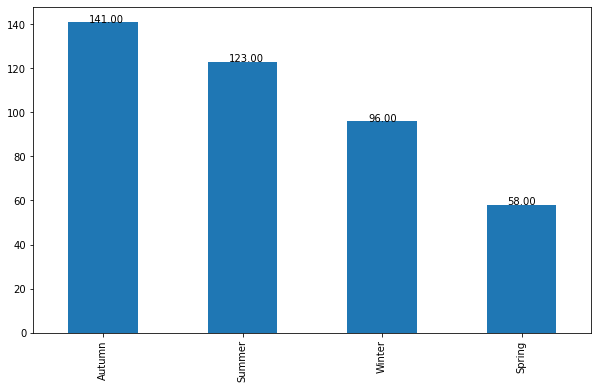

In [1235]:
ax = data['Season'].value_counts().plot(kind = 'bar', figsize = (10, 6))

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))
plt.show()

Autumn and summer has more accidents.

### Bivariate analysis of Seasons w.r.t Accident Level shows that Summer and winter seasons has more number of accidents

In [1236]:
import holidays

In [1237]:
brazil_holidays = []
for date in holidays.Brazil(years = 2016).items():
    brazil_holidays.append(str(date[0]))    
for date in holidays.Brazil(years = 2017).items():
    brazil_holidays.append(str(date[0]))    
brazil_holidays

['2016-01-01',
 '2016-04-21',
 '2016-05-01',
 '2016-09-07',
 '2016-10-12',
 '2016-11-02',
 '2016-11-15',
 '2016-12-25',
 '2016-03-25',
 '2016-03-27',
 '2016-05-26',
 '2016-02-10',
 '2016-02-09',
 '2017-01-01',
 '2017-04-21',
 '2017-05-01',
 '2017-09-07',
 '2017-10-12',
 '2017-11-02',
 '2017-11-15',
 '2017-12-25',
 '2017-04-14',
 '2017-04-16',
 '2017-06-15',
 '2017-03-01',
 '2017-02-28']

In [1238]:
data['isHoliday'] = [1 if str(val).split()[0] in brazil_holidays 
                     else 0 for val in data['Date']]
data.head(3)

,Date,Country,Local,Industry_sector,Accident_Level,Potential_Accident_Level,Gender,Employee_Third_Party,Critical_Risk,Description,Year,Month,Day,Weekday,Season,isHoliday
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,Summer,1
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,Summer,0
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,Summer,0


In [1239]:
data['isHoliday'].value_counts()

0    408
1     10
Name: isHoliday, dtype: int64

In [1240]:
data['Country'].value_counts()

Country_01    248
Country_02    129
Country_03     41
Name: Country, dtype: int64

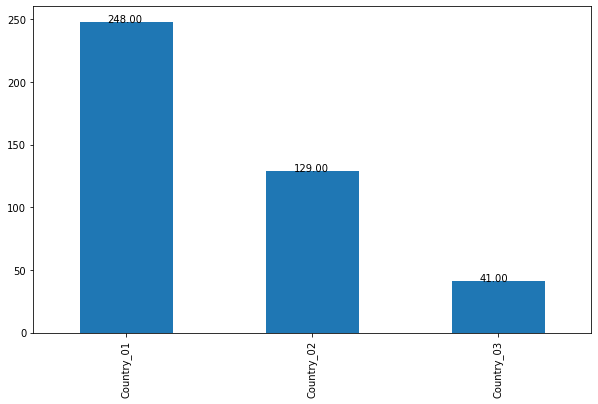

In [1241]:
ax = data['Country'].value_counts().plot(kind = 'bar', figsize = (10, 6))

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))
plt.show()

Country_01 has higher number of accidents

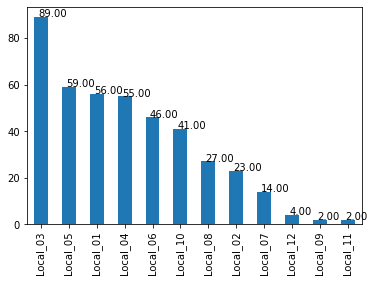

In [1242]:
ax = data['Local'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))

Local_03, 05,01,04,06,10 has more number of accidents.

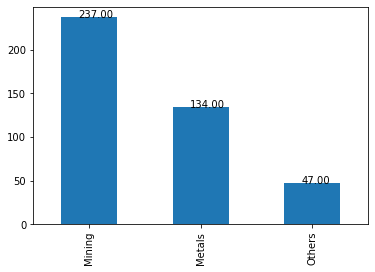

In [1243]:
ax = data['Industry_sector'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))

### Mining industry sector has larger number of accidents 
### Most of the accidents happened on working days. Few accidents are observed on holidays as well.
### Autumn and Summer seasons have more accidents compared to other seasons.
### Country_01 has 59 % of accidents.

In [1244]:
acc_percentages =(data['Accident_Level'].value_counts()/data.shape[0])*100
acc_levels = data['Accident_Level'].unique()
potacc_percentages = (data['Potential_Accident_Level'].value_counts()/data.shape[0])*100

accident_levels_df = pd.concat([acc_percentages,potacc_percentages], axis = 1).fillna(0)
accident_levels_df
#accident_levels_df = pd.melt(accident_levels_df.reset_index(), ['index']).rename(columns={'index':'Severity', 'variable':'Levels'})

,Accident_Level,Potential_Accident_Level
I,73.923445,10.765550
II,9.569378,22.727273
III,7.416268,25.358852
IV,7.177033,33.732057
V,1.913876,7.177033
VI,0.000000,0.239234


In [1245]:
#accident_levels_df.drop('level_0',axis=1,inplace = True)
accident_levels_df.reset_index(inplace = True)
accident_levels_df

,index,Accident_Level,Potential_Accident_Level
0,I,73.923445,10.765550
1,II,9.569378,22.727273
2,III,7.416268,25.358852
3,IV,7.177033,33.732057
4,V,1.913876,7.177033
5,VI,0.000000,0.239234


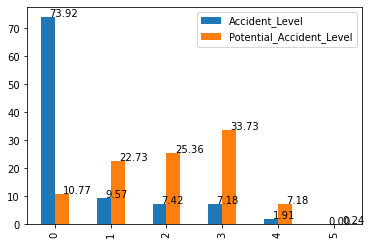

In [1246]:
ax = accident_levels_df.plot(kind='bar')
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))

Percentage of accident levels:
More number of accidents in Accidents( approx. 74 %) level I.

In [1247]:
data['Gender'].value_counts()

Male      396
Female     22
Name: Gender, dtype: int64

### 74 % accidents are with accident level I
### Males have more number of accidents compared to females
### More number of accidents with Level IV in potential accident level
### For employee types employee and third party have highest numbers than third party remote type
### Under mining industry sector there are more number of accidents for male employees
### Critical risk under the others category has highest count

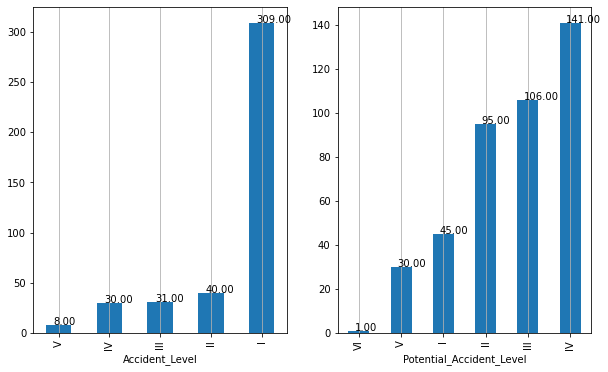

In [1248]:
fig,ax = plt.subplots(1,2,figsize=(10,6))

data['Accident_Level'].reset_index().groupby('Accident_Level').count().sort_values(by= 
       "index").plot(kind="bar", legend=False, 
        ax=ax[0]).grid(axis='x')

pot_acc_level = data['Potential_Accident_Level'].reset_index().groupby('Potential_Accident_Level').count().sort_values(by= 
       "index")
pot_acc_level.plot(kind="bar", legend=False, 
        ax=ax[1]).grid(axis='x')

for p in ax[0].patches:
    ax[0].annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))
for p in ax[1].patches:
    ax[1].annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))
plt.show()

Accident level I has more number in both Accident_Level and Potential_Accident_Level columns.

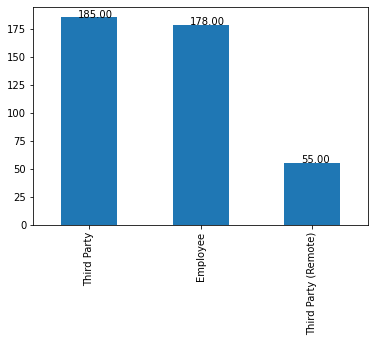

In [1249]:
ax = data['Employee_Third_Party'].value_counts().plot(kind = 'bar')
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))

Third party and employee type has more accidents than third party remote type

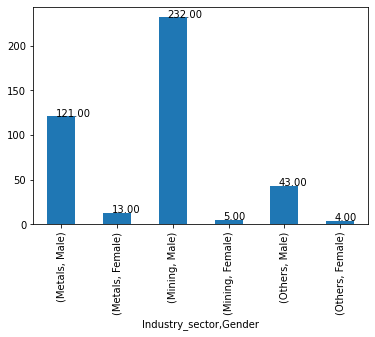

In [1250]:
ax = data.groupby('Industry_sector')['Gender'].value_counts().plot(kind = 'bar')
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))

Bivariate aalysis of Industry sector vs Gender shows Male with mining sector and metals has higher number of accidents.

In [1251]:
cri_risk = data['Critical_Risk'].value_counts().sort_values(ascending = False).index
cri_risk

Index(['Others', 'Pressed', 'Manual Tools', 'Chemical substances', 'Cut',
       'Venomous Animals', 'Projection', 'Bees', 'Fall',
       'Vehicles and Mobile Equipment', 'Fall prevention (same level)',
       'remains of choco', 'Pressurized Systems', 'Fall prevention',
       'Suspended Loads', 'Power lock', 'Liquid Metal',
       'Pressurized Systems / Chemical Substances',
       'Blocking and isolation of energies', 'Machine Protection',
       'Electrical Shock', 'Poll', 'Individual protection equipment',
       'Projection/Manual Tools', 'Burn', 'Electrical installation',
       'Projection/Choco', 'Projection/Burning', 'Plates', 'Confined space',
       'Traffic', '\nNot applicable', 'Projection of fragments'],
      dtype='object')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Others'),
  Text(1, 0, 'Pressed'),
  Text(2, 0, 'Manual Tools'),
  Text(3, 0, 'Chemical substances'),
  Text(4, 0, 'Cut'),
  Text(5, 0, 'Venomous Animals'),
  Text(6, 0, 'Projection'),
  Text(7, 0, 'Bees'),
  Text(8, 0, 'Fall'),
  Text(9, 0, 'Vehicles and Mobile Equipment'),
  Text(10, 0, 'Fall prevention (same level)'),
  Text(11, 0, 'remains of choco'),
  Text(12, 0, 'Pressurized Systems'),
  Text(13, 0, 'Fall prevention'),
  Text(14, 0, 'Suspended Loads'),
  Text(15, 0, 'Power lock'),
  Text(16, 0, 'Liquid Metal'),
  Text(17, 0, 'Pressurized Systems / Chemical Substances'),
  Text(18, 0, 'Blocking and isolation of energies'),
  Text(19, 0, 'Machine Protection'),
  Text(20, 0, 'Electrical Shock'),
  Text(21, 0, 'Poll'),
  Text(22, 0, 'Individual protection equipment'),
  Text(23, 0, 'Projection/Manual Tools'),
  Text(24, 0

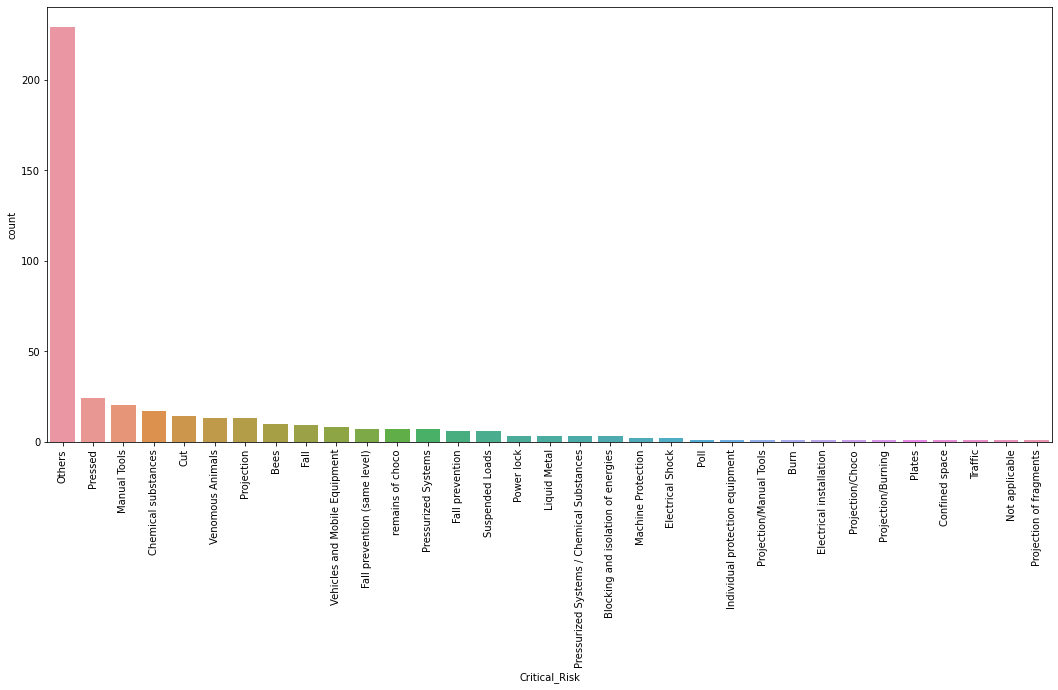

In [1252]:
plt.figure(figsize=(18,8))
sns.countplot(x = data['Critical_Risk'], order = cri_risk)
plt.xticks(rotation = 90)

In [1253]:
columns = ['Gender','Country','Employee_Third_Party','Industry_sector','Season','Month']

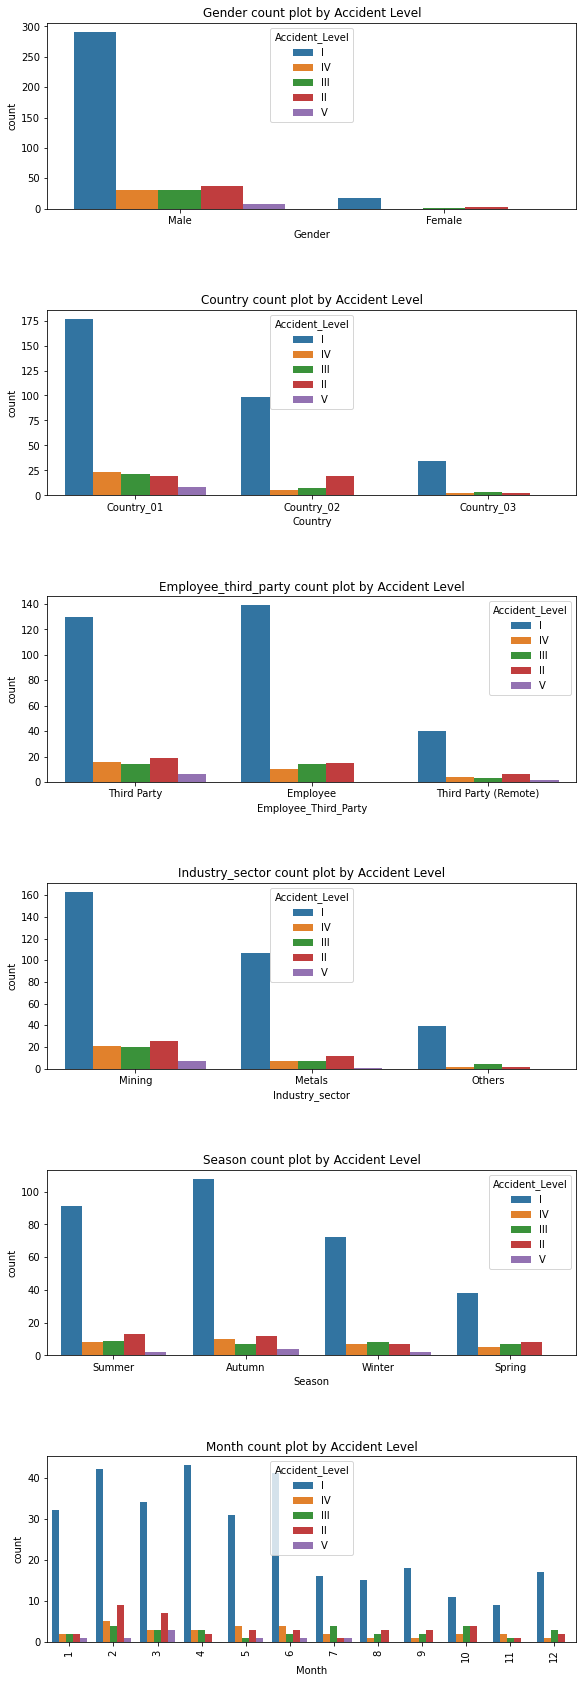

In [1254]:
i = 0

fig,axs = plt.subplots(6,1,figsize=(10,25))
fig.tight_layout(pad=8.0)
plt.xticks(rotation = 90)
for col in columns:
    labels = data[col].value_counts().index
    axs[i] = sns.countplot(x = col, data = data, ax = axs[i], orient = 'v',
                  hue = 'Accident_Level').set_title(col.capitalize() +' count plot by Accident Level',fontsize=12)
    
    i = i+1
    
plt.show()


Bivariate plots of columns 'Gender','Country','Employee_Third_Party','Industry_sector','Season','Month' w.r.t. Accident level shows that:
1. Male has more number of accidents in accident level I.
2. All countries have more accidents in Level I.
3. All type of employess have accident level I as higher count.
4. In all industry sectors,seasons and months accident level I as higher count.
5. Others category of critical_risk have more number of accidents.

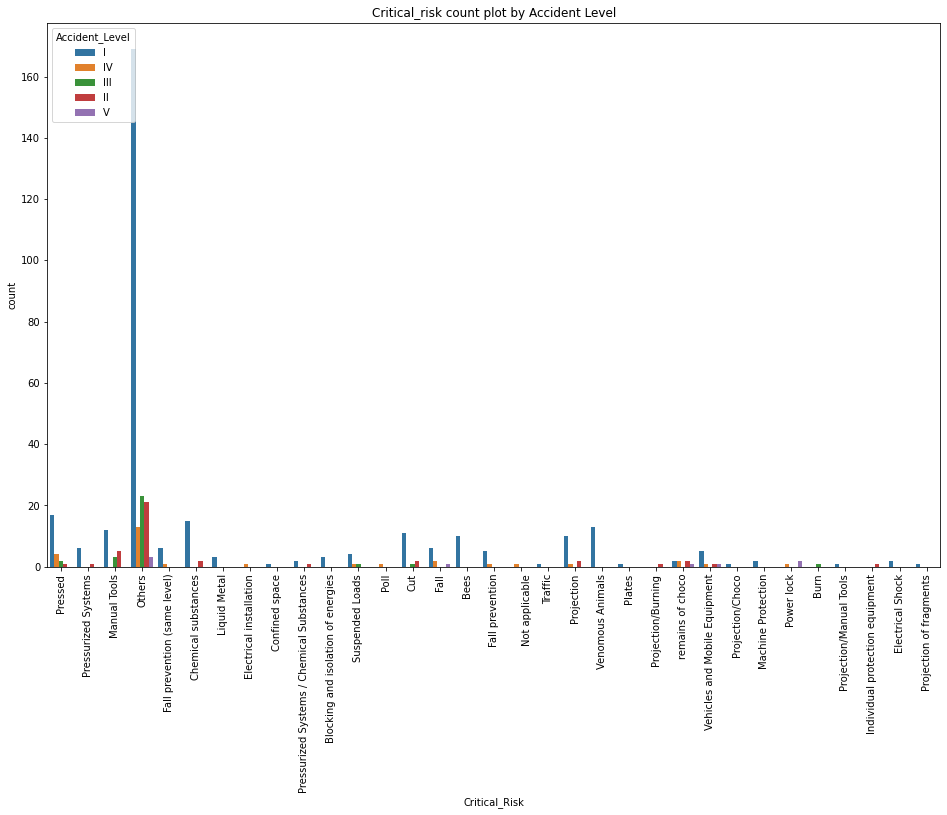

In [1255]:
plt.figure(figsize = (16,10))
sns.countplot(x = 'Critical_Risk', data = data, orient = 'v',
                  hue = 'Accident_Level').set_title('Critical_Risk'.capitalize() +' count plot by Accident Level',fontsize=12)
plt.xticks(rotation = 90)
plt.show()

### Critical risk others with accident level I has more number of counts.

In [1256]:
data['nSentences'] = data['Description'].apply(sent_tokenize).tolist()
data['nSentences'] = data['nSentences'].apply(len)
data['nSentences'].value_counts()

1    181
2    131
3     61
4     24
5     12
6      6
8      2
7      1
Name: nSentences, dtype: int64

### Most of the descriptions in the dataset has 1 and 2 line descriptions.
### Observed the number of words in the description and found most descriptions are containing words in the range 37 to 79

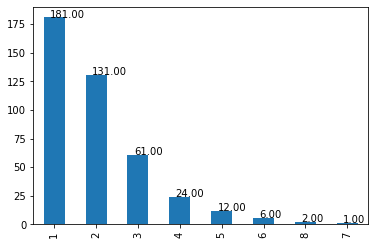

In [1257]:
ax = data['nSentences'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))

In [1258]:
count_words = lambda x: len(word_tokenize(x))
data['nWords'] =  data['Description'].apply(count_words)
data['nWords'].head()

0     84
1     59
2     62
3    110
4    100
Name: nWords, dtype: int64

Text(0.5, 0, 'Row number')

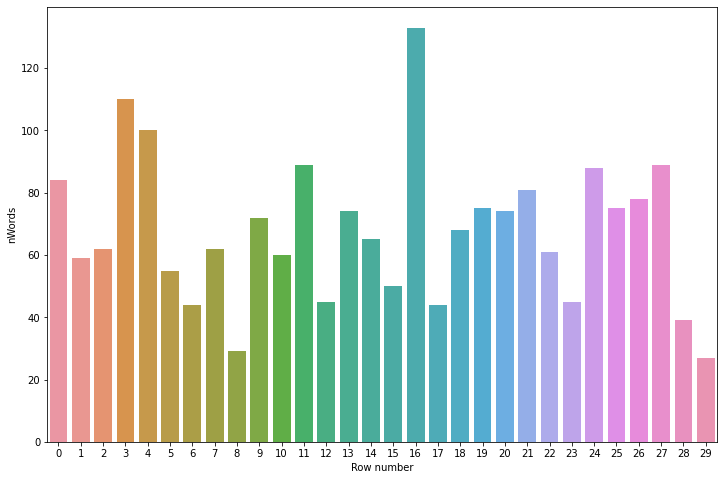

In [1259]:
plt.figure(figsize = (12,8))
wordcounts = data['nWords'][0:30]
sns.barplot(x = wordcounts.index,  y=wordcounts)
plt.xlabel("Row number")

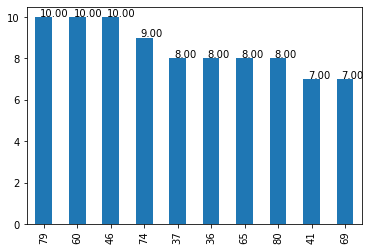

In [1260]:
ax= data['nWords'].value_counts().sort_values(ascending = False)[0:10].plot(kind='bar')
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))

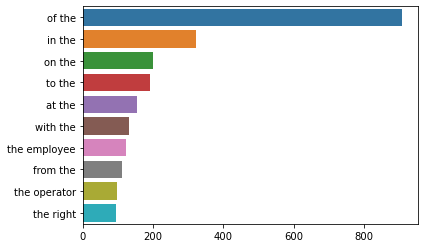

In [1261]:

def top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

def ngram_barchart(text, n=None):
    lines = text.str.split()
    lines =lines.values.tolist()
    corpus=[word for word in lines]

    top_n_bigrams= top_ngrams(text,n)[:15]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
ngram_barchart(data['Description'],2)


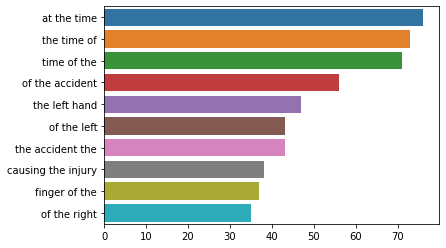

In [1262]:
ngram_barchart(data['Description'],3)

In [1263]:
from nltk.corpus import stopwords
def preprocess(text):
    corpus=[]
    lemmatizer = WordNetLemmatizer()
    for lines in text:
            words=word_tokenize(lines)
            words = [word for word in words if word not in stopwords.words('english')]
            words=[lemmatizer.lemmatize(w) for w in words if len(w)>2]
            corpus.append(words)
    return corpus
    

In [1264]:
def plot_wordcloud(text):
    wordcloud = WordCloud(
        background_color='black',
        colormap = 'rainbow',
        #stopwords=set(STOPWORDS),
        max_words=250,
        min_font_size = 5,
        max_font_size=25, 
        scale=4,
        collocations=False,
        random_state=1)
    corpus = preprocess(text)
    wordcloud=wordcloud.generate(str(corpus))
    plt.figure(figsize=(18, 16))
    plt.axis('off') 
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.show()
   

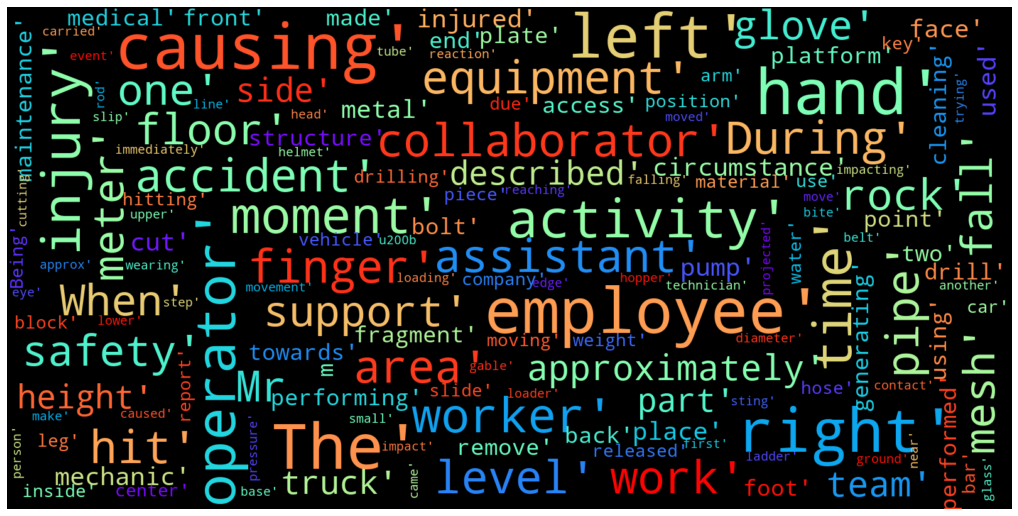

In [1265]:
plot_wordcloud(data['Description'])

### Observations
#### Most of the words in the corpus
#### Body-parts: left, right, hand, finger, face, foot,head and glove
#### Person: employee, operator, collaborator, assistant, worker and mechanic
#### Movement: fall, hit, lift and slip
#### Equipment: equipment, pipe,pump, meter, drill, truck and tube
#### Accident: accident, activity, safety, injury, causing

### Regular expressions to extract numbers from description column

In [1266]:
import re
def find_numbers(text):  
    
    numbers = re.findall(r'\w*\d\.*\:*\-*[\w\d]+w*\.*\:*\-*', text)
    res = list((numbers))  
    return res
data['Numbers_in_description'] = data['Description'].apply(find_numbers)
data['Numbers_in_description'].head(20)


0                                [08]
1                                [48]
2                               [170]
3                   [9:45, 1880, 695]
4     [11:45, 3015, 27, 33, 70, 1.06]
5                                  []
6                                [09]
7                        [04:50, 100]
8                               [326]
9                           [70, 069]
10              [60x4x5cm, 1.2, 1.50]
11                      [60, 35, 200]
12                                 []
13            [544, 3300, 440V, 400A]
14                         [08FI0502]
15                                 []
16                        [050, 1620]
17                                 []
18                        [G2133, 75]
19                                 []
Name: Numbers_in_description, dtype: object

### Found numbers in the description. Most numbers are relevant and should not be removed.

### Data Preprocessing to be ready for ML models

## Remove unwanted columns from the dataframe

In [1267]:
columns_to_drop = ['Date', 'Country', 'Local', 'Industry_sector', 'Potential_Accident_Level', 'Gender', 'Employee_Third_Party',
       'Year', 'Month', 'Day', 'Weekday','Season', 'isHoliday', 'nSentences', 'nWords','Numbers_in_description']
data.drop(columns_to_drop, axis = 1,inplace = True)
data.head()

,Accident_Level,Critical_Risk,Description
0,I,Pressed,While removing the drill rod of the Jumbo 08 f...
1,I,Pressurized Systems,During the activation of a sodium sulphide pum...
2,I,Manual Tools,In the sub-station MILPO located at level +170...
3,I,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,IV,Others,Approximately at 11:45 a.m. in circumstances t...


### Join two columns Critical_Risk and Description

In [1268]:
data['Description'] = data[['Critical_Risk','Description']].apply(lambda x: ' '.join(x), axis =1)

In [1269]:
data['Description'].head()

0    Pressed While removing the drill rod of the Ju...
1    Pressurized Systems During the activation of a...
2    Manual Tools In the sub-station MILPO located ...
3    Others Being 9:45 am. approximately in the Nv....
4    Others Approximately at 11:45 a.m. in circumst...
Name: Description, dtype: object

In [1270]:
lemmatizer = WordNetLemmatizer()

In [1271]:
def preprocess_description(text):           
        
        text = ''.join(re.findall(r'[a-zA-Z0-9 ]',text))        
        text = text.lower()
        text = text.strip()        
        words = word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if len(word)>2]
        text = ' '.join(words)        
        return text    

In [1272]:
i = 0
data['clean_description'] = ""
for desc in data['Description']:
    data['clean_description'].iloc[i] = preprocess_description(data['Description'].iloc[i])    
    i = i+1
data['clean_description'].head()

0    pressed while removing the drill rod the jumbo...
1    pressurized system during the activation sodiu...
2    manual tool the substation milpo located level...
3    others being 945 approximately the 1880 cx695 ...
4    others approximately 1145 circumstance that th...
Name: clean_description, dtype: object

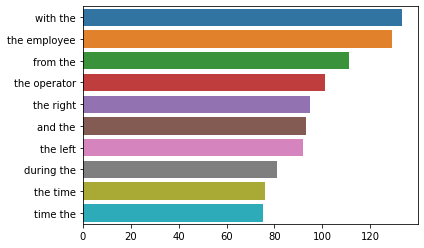

In [1273]:
ngram_barchart(data['clean_description'],2)

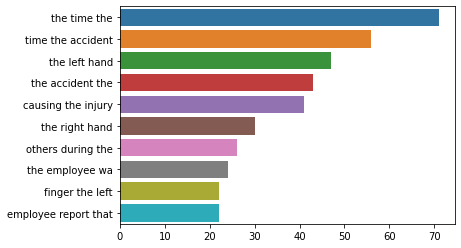

In [1274]:
ngram_barchart(data['clean_description'],3)

In [1275]:
data.head()

,Accident_Level,Critical_Risk,Description,clean_description
0,I,Pressed,Pressed While removing the drill rod of the Ju...,pressed while removing the drill rod the jumbo...
1,I,Pressurized Systems,Pressurized Systems During the activation of a...,pressurized system during the activation sodiu...
2,I,Manual Tools,Manual Tools In the sub-station MILPO located ...,manual tool the substation milpo located level...
3,I,Others,Others Being 9:45 am. approximately in the Nv....,others being 945 approximately the 1880 cx695 ...
4,IV,Others,Others Approximately at 11:45 a.m. in circumst...,others approximately 1145 circumstance that th...


In [1276]:
new_data = data.drop(['Critical_Risk'], axis = 1)

In [1277]:
new_data.head()

,Accident_Level,Description,clean_description
0,I,Pressed While removing the drill rod of the Ju...,pressed while removing the drill rod the jumbo...
1,I,Pressurized Systems During the activation of a...,pressurized system during the activation sodiu...
2,I,Manual Tools In the sub-station MILPO located ...,manual tool the substation milpo located level...
3,I,Others Being 9:45 am. approximately in the Nv....,others being 945 approximately the 1880 cx695 ...
4,IV,Others Approximately at 11:45 a.m. in circumst...,others approximately 1145 circumstance that th...


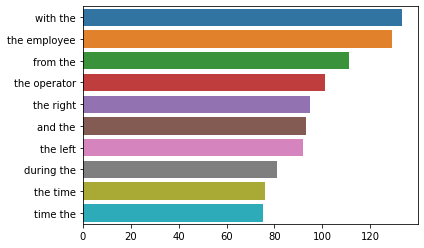

In [1278]:
ngram_barchart(new_data['clean_description'],2)

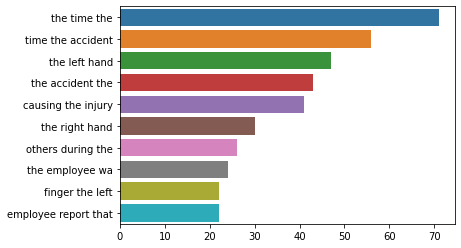

In [1279]:
ngram_barchart(new_data['clean_description'],3)

In [1280]:
encoder = LabelEncoder()
new_data['Accident_Level'] = encoder.fit_transform(new_data['Accident_Level'])
new_data.head()

,Accident_Level,Description,clean_description
0,0,Pressed While removing the drill rod of the Ju...,pressed while removing the drill rod the jumbo...
1,0,Pressurized Systems During the activation of a...,pressurized system during the activation sodiu...
2,0,Manual Tools In the sub-station MILPO located ...,manual tool the substation milpo located level...
3,0,Others Being 9:45 am. approximately in the Nv....,others being 945 approximately the 1880 cx695 ...
4,3,Others Approximately at 11:45 a.m. in circumst...,others approximately 1145 circumstance that th...


In [1281]:
new_data['Accident_Level'].value_counts()

0    309
1     40
2     31
3     30
4      8
Name: Accident_Level, dtype: int64

#### Critical_Risk and descritption columns are the features and Accident_Level is the target variable.
#### Dataset is imbalanced consisting of more numbers for accidents level I. So needs oversampling for minority classes.
#### SMOTE is used for oversampling.

In [1282]:
new_data.head()

,Accident_Level,Description,clean_description
0,0,Pressed While removing the drill rod of the Ju...,pressed while removing the drill rod the jumbo...
1,0,Pressurized Systems During the activation of a...,pressurized system during the activation sodiu...
2,0,Manual Tools In the sub-station MILPO located ...,manual tool the substation milpo located level...
3,0,Others Being 9:45 am. approximately in the Nv....,others being 945 approximately the 1880 cx695 ...
4,3,Others Approximately at 11:45 a.m. in circumst...,others approximately 1145 circumstance that th...


In [1283]:
oversample = SMOTE()
X = new_data['clean_description']
y = new_data['Accident_Level']


In [1284]:
count_vect = CountVectorizer(ngram_range=(1,3))
new_X = count_vect.fit_transform(X)
print(new_X)


  (0, 18615)	1
  (0, 31263)	1
  (0, 19897)	1
  (0, 23773)	17
  (0, 7606)	2
  (0, 20480)	1
  (0, 13155)	2
  (0, 9789)	1
  (0, 14634)	1
  (0, 22876)	1
  (0, 18846)	1
  (0, 14331)	1
  (0, 22900)	3
  (0, 12887)	1
  (0, 5352)	1
  (0, 9014)	1
  (0, 19811)	2
  (0, 21110)	1
  (0, 28049)	3
  (0, 15023)	2
  (0, 16392)	1
  (0, 8354)	1
  (0, 8536)	1
  (0, 19142)	1
  (0, 31458)	1
  :	:
  (417, 13741)	1
  (417, 168)	1
  (417, 24035)	1
  (417, 3303)	1
  (417, 5724)	1
  (417, 25223)	1
  (417, 9650)	1
  (417, 15555)	1
  (417, 24353)	1
  (417, 5339)	1
  (417, 4908)	1
  (417, 21259)	1
  (417, 21771)	1
  (417, 3572)	1
  (417, 2252)	1
  (417, 12347)	1
  (417, 10764)	1
  (417, 25766)	1
  (417, 13453)	1
  (417, 23157)	1
  (417, 3549)	1
  (417, 9142)	1
  (417, 25228)	1
  (417, 9664)	1
  (417, 22790)	1


In [1285]:
len(count_vect.get_feature_names_out())

32283

In [1286]:
X,y = oversample.fit_resample(new_X, y)

In [1287]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1288]:
df1 = pd.DataFrame(X.toarray(), columns = count_vect.get_feature_names_out())

In [1289]:
#df1 = pd.DataFrame(X)
df2 = pd.DataFrame(y)

In [1290]:
df1.shape

(1545, 32283)

In [1291]:
new_data1 = pd.concat([df1,df2],axis =1)
new_data1.head()

,001,001 1710,001 1710 ob1,0010,0010 time,0010 time when,007,007 bp105,007 bp105 parking,01022017,...,zone intersection rpa,zone lifting,zone lifting container,zone moment,zone moment that,zone the,zone the victim,zone with,zone with the,Accident_Level
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [1294]:
new_data1.to_csv("cleaned_industry_safety_data.csv")

In [1293]:
#new_data.to_csv("cleaned_industry_safety_data.csv")

### Applied preprocessing steps to clean text data.
### Only achracters A-Za-z0-9 and space is kept. Other characters are removed. 
### Snowball stemmer is used to get base words and text is then converted to lowercase.
### bi-gram and tri-grams are observed on the cleaned data.
### Cleaned data is stored in csv file.